# Importación de Bibliotecas

In [48]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
import nltk
from scipy.sparse import csr_matrix

# Carga de datos y Preprocesamiento

Importamos el dataset de entrenamiento

In [54]:
df = pd.read_csv("./train_normalizado_stemming.csv")

ds_trabajo = df.copy()
ds_trabajo.head(5)

,ID,review_es,sentimiento
0,0,uno de los otros critic ha mencion que despues...,positivo
1,1,una pequeñ pequeñ produccion la tecnic de film...,positivo
2,2,pens que esta era una maner maravill de pas ti...,positivo
3,3,basic hay una famili dond un niñ pequeñ jak pi...,negativo
4,4,el amor en el tiemp de pett mattei es una peli...,positivo


In [50]:
stopwords = nltk.corpus.stopwords.words('spanish')

In [51]:
import re
ds_trabajo.review_es = ds_trabajo.review_es.str.lower();
ds_trabajo.review_es = ds_trabajo.review_es.apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
ds_trabajo.review_es

0       la mayor virtud de esta película es su existen...
1       no soy un experto cinéfilo  pero pocas veces m...
2       si no eres un incondicional del humor estilo t...
3       no sé qué está pasando  si la gente se deja ll...
4       pero cuando amanece y me quedo solo siento en ...
                              ...                        
8594    buena no  lo siguiente  por fin un film serio ...
8595    me esperaba mucho  pero que mucho  más guión m...
8596    de mal cuerpo como sensación al finalizar  de ...
8597    los que han añadido comentarios os lo han dich...
8598    fui a ver esta película de cine con entusiasmo...
Name: review_es, Length: 8599, dtype: object

In [52]:
import pandas as pd
# import spacy

# # Cargar el modelo de idioma español en spaCy
# nlp = spacy.load('es_core_news_sm')

# # Realizar la lematización en la columna 'Texto'
# ds_trabajo.review_es = ds_trabajo.review_es.apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))

# print(ds_trabajo.review_es)

from nltk.stem import SnowballStemmer

# Inicializar el stemmer para español
stemmer = SnowballStemmer('spanish')

# Realizar el stemming en la columna 'Texto'
ds_trabajo.review_es = ds_trabajo.review_es.apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

print(ds_trabajo.review_es)


0       la mayor virtud de esta pelicul es su existent...
1       no soy un expert cinefil per poc vec me hab se...
2       si no eres un incondicional del humor estil te...
3       no se que esta pas si la gent se dej llev por ...
4       per cuand amanec y me qued sol sient en el fon...
                              ...                        
8594    buen no lo siguient por fin un film seri con u...
8595    me esper much per que much mas guion muy vist ...
8596    de mal cuerp com sensacion al finaliz de histo...
8597    los que han añad comentari os lo han dich clar...
8598    fui a ver esta pelicul de cin con entusiasm lo...
Name: review_es, Length: 8599, dtype: object


In [53]:
# ds_trabajo.to_csv('train_normalizado_stemming.csv', index=False)
ds_trabajo.to_csv('test_normalizado_stemming.csv', index=False)

# Modelo 1 (overfitteó)

In [55]:
preprocesador = CountVectorizer(stop_words=stopwords)

textos_entrenamiento, textos_prueba, etiquetas_entrenamiento, etiquetas_prueba = train_test_split(ds_trabajo.review_es, ds_trabajo.sentimiento, test_size=0.2, random_state=42)

vectorizador = preprocesador.fit(textos_entrenamiento)
caracteristicas_entrenamiento = vectorizador.transform(textos_entrenamiento)
caracteristicas_prueba = vectorizador.transform(textos_prueba)

modelo = MultinomialNB(alpha=1)
modelo.fit(caracteristicas_entrenamiento, etiquetas_entrenamiento)

predicciones = modelo.predict(caracteristicas_prueba)

print("La accuracy es {}".format(accuracy_score(etiquetas_prueba, predicciones)))
print("La precision es {}".format(precision_score(etiquetas_prueba, predicciones, average='macro')))
print("El recall es {}".format(recall_score(etiquetas_prueba, predicciones, average='macro')))
print("El F1 es {}".format(f1_score(etiquetas_prueba, predicciones, average='macro')))



La accuracy es 0.8335
La precision es 0.8359621578099838
El recall es 0.8338323103577622
El F1 es 0.8332827323896776


Text(50.722222222222214, 0.5, 'True')

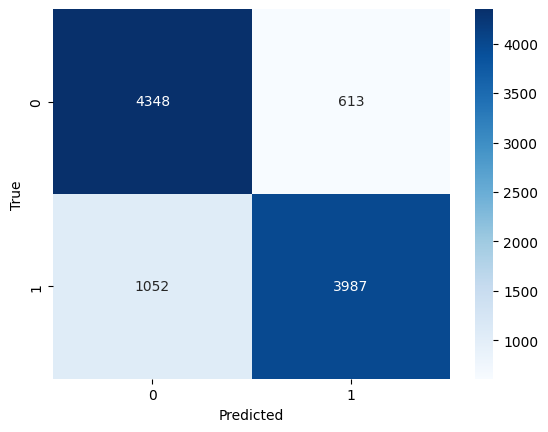

In [56]:
cm = confusion_matrix(etiquetas_prueba,predicciones)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')


In [57]:
import pickle

with open('./models/naive_bayes/nb_model.pickle', 'wb') as archivo:
    pickle.dump(modelo, archivo)

In [58]:
with open('./models/naive_bayes/nb_model.pickle', 'rb') as archivo:
    modelo_cargado = pickle.load(archivo)

ds_test = pd.read_csv('./test_normalizado_stemming.csv')
ds_submission = ds_test.copy()

nuevas_caracteristicas = vectorizador.transform(ds_submission.review_es)
predicciones_nuevas = modelo_cargado.predict(nuevas_caracteristicas)

df_submission = pd.DataFrame({'ID': ds_submission.ID, 'sentimiento': predicciones_nuevas})
df_submission.head()
df_submission.to_csv('submissions/naive_bayes/nb_submission.csv', index=False)

# Modelo 2

In [59]:
X_train, X_test, y_train, y_test = train_test_split(ds_trabajo.review_es, ds_trabajo.sentimiento, test_size=0.2, random_state=42)

# Crear un objeto TfidfVectorizer con stopwords en español
vectorizador = TfidfVectorizer(stop_words=stopwords)

# Ajustar y transformar los datos de entrenamiento
X_train_transformado = vectorizador.fit_transform(X_train)

# Transformar los datos de prueba
X_test_transformado = vectorizador.transform(X_test)

# Crear el modelo Naive Bayes Multinomial
modelo_2 = MultinomialNB()

# Entrenar el modelo con los datos de entrenamiento
modelo_2.fit(X_train_transformado, y_train)

MultinomialNB()

In [60]:
predicciones = modelo_2.predict(X_test_transformado)

print("La accuracy es {}".format(accuracy_score(etiquetas_prueba, predicciones)))
print("La precision es {}".format(precision_score(etiquetas_prueba, predicciones, average='macro')))
print("El recall es {}".format(recall_score(etiquetas_prueba, predicciones, average='macro')))
print("El F1 es {}".format(f1_score(etiquetas_prueba, predicciones, average='macro')))

La accuracy es 0.8427
La precision es 0.8429911629098361
El recall es 0.8428144568315536
El F1 es 0.8426896788698306


Text(50.722222222222214, 0.5, 'True')

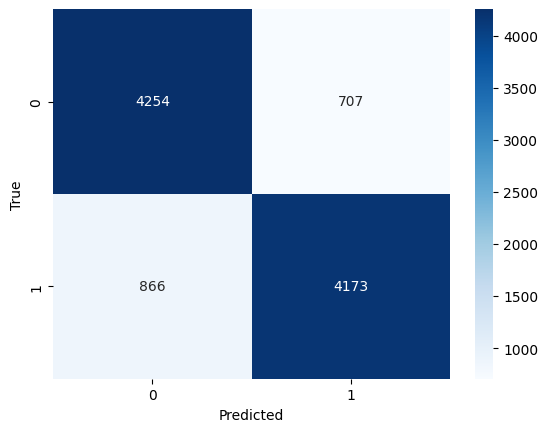

In [61]:
cm = confusion_matrix(etiquetas_prueba,predicciones)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')


In [62]:
import pickle

with open('./models/naive_bayes/nb_model2.pickle', 'wb') as archivo:
    pickle.dump(modelo_2, archivo)

In [63]:
with open('./models/naive_bayes/nb_model2.pickle', 'rb') as archivo:
    modelo_cargado = pickle.load(archivo)

ds_test = pd.read_csv('./test_normalizado_stemming.csv')
ds_submission = ds_test.copy()

nuevas_caracteristicas = vectorizador.transform(ds_submission.review_es)
predicciones_nuevas = modelo_cargado.predict(nuevas_caracteristicas)

df_submission = pd.DataFrame({'ID': ds_submission.ID, 'sentimiento': predicciones_nuevas})
df_submission.head()
df_submission.to_csv('submissions/naive_bayes/nb_submission2.csv', index=False)